# In this notebook we fit a SEIR model with hidden states to the Moscow Covid-19 data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.integrate import odeint
from sklearn.metrics import mean_absolute_error
import lmfit
from tqdm.auto import tqdm
import pickle

In [2]:
sns.set()
%matplotlib inline

In [3]:
%load_ext autoreload

In [4]:
%autoreload 2

In [5]:
from sir_models.models import SEIRHidden
from sir_models.fitters import HiddenCurveFitter
from sir_models.utils import stepwise, eval_on_select_dates_and_k_days_ahead

# Load data

In [6]:
df = pd.read_csv('data/moscow_prepared.csv', parse_dates=['date'])

In [7]:
df['date'] = pd.date_range(start=df.date.iloc[0], end=df.date.iloc[-1], freq='D')

In [8]:
df.head()

,date,total_infected,total_recovered,total_dead,deaths_per_day,infected_per_day,recovered_per_day,infected,total_infected_ma7,total_recovered_ma7,total_dead_ma7,deaths_per_day_ma7,infected_per_day_ma7,recovered_per_day_ma7,infected_ma7
0,2020-03-12,21,0,0,0,21,0,21,21.0,0.0,0.0,0.0,21.0,0.0,21.0
1,2020-03-13,26,0,0,0,5,0,26,26.0,0.0,0.0,0.0,5.0,0.0,26.0
2,2020-03-14,35,0,0,0,9,0,35,35.0,0.0,0.0,0.0,9.0,0.0,35.0
3,2020-03-15,35,1,0,0,0,1,34,35.0,1.0,0.0,0.0,0.0,1.0,34.0
4,2020-03-16,53,1,0,0,18,0,52,53.0,1.0,0.0,0.0,18.0,0.0,52.0


# Model

In [9]:
train_subset = df[
    #(df.date >= '2020-03-25') &
    (df.date <= '2021-02-01')]

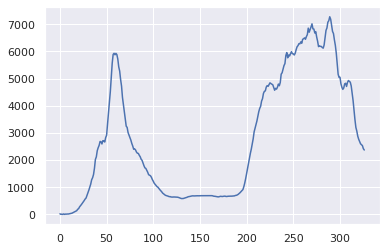

In [10]:
train_subset.infected_per_day_ma7.plot()
plt.show()

In [11]:
test_subset = df[df.date > train_subset.iloc[-1].date]
test_subset.date[:3]

327   2021-02-02
328   2021-02-03
329   2021-02-04
Name: date, dtype: datetime64[ns]

In [12]:
train_subset.head()

,date,total_infected,total_recovered,total_dead,deaths_per_day,infected_per_day,recovered_per_day,infected,total_infected_ma7,total_recovered_ma7,total_dead_ma7,deaths_per_day_ma7,infected_per_day_ma7,recovered_per_day_ma7,infected_ma7
0,2020-03-12,21,0,0,0,21,0,21,21.0,0.0,0.0,0.0,21.0,0.0,21.0
1,2020-03-13,26,0,0,0,5,0,26,26.0,0.0,0.0,0.0,5.0,0.0,26.0
2,2020-03-14,35,0,0,0,9,0,35,35.0,0.0,0.0,0.0,9.0,0.0,35.0
3,2020-03-15,35,1,0,0,0,1,34,35.0,1.0,0.0,0.0,0.0,1.0,34.0
4,2020-03-16,53,1,0,0,18,0,52,53.0,1.0,0.0,0.0,18.0,0.0,52.0


In [13]:
stepwize_size = 60

weights = {
    'I': 0.25,
    'R': 0.25,
    'D': 0.5,
}
model = SEIRHidden(stepwise_size=stepwize_size)
fitter = HiddenCurveFitter(
     new_deaths_col='deaths_per_day_ma7',
     new_cases_col='infected_per_day_ma7',
     new_recoveries_col='recovered_per_day_ma7',
     
     weights=weights,
     max_iters=1000,
     save_params_every=50,
)
fitter.fit(model, train_subset)

KeyboardInterrupt: 

In [ ]:
result = fitter.result
result

In [ ]:
incubation_days = model.params['incubation_days'].value
infectious_days = model.params['infectious_days'].value
print(f'Incubation period: {incubation_days:.2f}')
print(f'Infectious period: {infectious_days:.2f}')

In [ ]:
train_initial_conditions = model.get_initial_conditions(train_subset)
train_t = np.arange(len(train_subset))

(S, E, I, Iv, R, Rv, D, Dv), history = model.predict(train_t, train_initial_conditions)
(new_exposed,
         new_infected_invisible, new_infected_visible,
         new_recovered_invisible,
         new_recovered_visible,
         new_dead_invisible, new_dead_visible) = model.compute_daily_values(S, E, I, Iv, R, Rv, D, Dv)

In [ ]:
daily_df = pd.DataFrame(
    {
        'date': train_subset.date[1:].values,
        'new_exposed': new_exposed,
        'new_infected_invisible': new_infected_invisible,
        'new_infected_visible': new_infected_visible,
        'new_recovered_invisible': new_recovered_invisible,
        'new_recovered_visible': new_recovered_visible,
        'new_dead_invisible': new_dead_invisible,
        'new_dead_visible': new_dead_visible
    },
    index=train_subset.date[1:])

In [ ]:
plt.figure()
history.rt.plot()
history.beta.plot()
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['total_dead'], label='ground truth')
plt.plot(train_subset.date, D, label='predicted invisible', color='black', linestyle='dashed' )
plt.plot(train_subset.date, Dv, label='predicted visible', color='black')
plt.legend()
plt.title('Total deaths')
plt.show()

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(daily_df.new_dead_visible, label='daily deaths_visible', color='black', linestyle='dashed')
plt.plot(daily_df.new_dead_invisible, label='daily deaths_invisible', color='black', linestyle=':')
plt.plot(train_subset.date, train_subset['deaths_per_day_ma7'], label='ground truth')
plt.legend()
plt.title('Daily deaths')
plt.show()

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['total_infected'], label='ground truth')
plt.plot(daily_df.new_infected_visible.cumsum(), label='predicted visible', color='red')
plt.plot(daily_df.new_infected_invisible.cumsum(), label='predicted invisible', color='red',  linestyle='dashed' )
plt.legend()
plt.title('Total infections')
plt.show()

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['infected_per_day_ma7'], label='ground truth')

plt.plot(daily_df.new_infected_visible, label='daily infected_visible', color='red')
plt.plot(daily_df.new_infected_invisible, label='daily infected_invisible', color='red', linestyle='dashed')
plt.legend()
plt.title('Daily infections')
plt.show()

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['infected'], label='ground truth')
plt.plot(train_subset.date, I, label='predicted')
plt.legend()
plt.title('Active cases')
plt.show()

# Obtain forecast

In [ ]:
test_t = len(train_subset) + np.arange(len(test_subset))

In [ ]:
train_t, test_t

In [ ]:
test_initial_conds = (S[-1], E[-1], I[-1], Iv[-1], R[-1], Rv[-1], D[-1], Dv[-1])

In [ ]:
(test_S, test_E, test_I, test_Iv, test_R, test_Rv, test_D, test_Dv), history = model.predict(test_t, test_initial_conds)

In [ ]:
(test_new_exposed,
         test_new_infected_invisible, test_new_infected_visible,
         test_new_recovered_invisible,
         test_new_recovered_visible,
         test_new_dead_invisible, test_new_dead_visible) = model.compute_daily_values(test_S, test_E, test_I, test_Iv, test_R, test_Rv, test_D, test_Dv)

In [ ]:
test_daily_df = pd.DataFrame(
    {
        'date': test_subset.date[1:].values,
        'new_exposed': test_new_exposed,
        'new_infected_invisible': test_new_infected_invisible,
        'new_infected_visible': test_new_infected_visible,
        'new_recovered_invisible': test_new_recovered_invisible,
        'new_recovered_visible': test_new_recovered_visible,
        'new_dead_invisible': test_new_dead_invisible,
        'new_dead_visible': test_new_dead_visible
    },
    index=test_subset.date[1:])

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['total_dead'], label='train ground truth')

plt.plot(test_subset.date, test_subset['total_dead'], label='test ground truth', color='black')
plt.plot(test_subset.date, test_D, label='test forecasted invisible', color='black', linestyle=':')
plt.plot(test_subset.date, test_Dv, label='test forecasted visible', color='black', linestyle='dashed')
plt.legend()
plt.title('Total deaths')
plt.show()

In [ ]:
plt.figure(figsize=(10, 7))
# plt.plot(train_subset.date[:-1], new_dead_visible, label='daily deaths_visible', color='black')
# plt.plot(train_subset.date[:-1], new_dead_invisible, label='daily deaths_invisible', color='black', linestyle='dashed')
plt.plot(train_subset.date, train_subset['deaths_per_day'], label='train ground truth')
plt.plot(test_subset.date, test_subset['deaths_per_day'], label='test ground truth', color='black')

plt.plot(test_daily_df.new_dead_invisible, label='test forecasted invisible', color='black', linestyle=':')
plt.plot(test_daily_df.new_dead_visible, label='test forecasted visible', color='black', linestyle='dashed')
plt.plot(daily_df.new_dead_visible, label='daily deaths_visible tain', color='black', alpha=0.5, linestyle='dashed')
plt.legend()
plt.title('Daily deaths')
plt.show()

In [ ]:
plt.figure(figsize=(10, 7))
# plt.plot(train_subset.date[:-1], new_dead_visible, label='daily deaths_visible', color='black')
# plt.plot(train_subset.date[:-1], new_dead_invisible, label='daily deaths_invisible', color='black', linestyle='dashed')
plt.plot(train_subset.date, train_subset['recovered_per_day'], label='train ground truth')

plt.plot(test_subset.date, test_subset['recovered_per_day'], label='test ground truth', color='green')
plt.plot(test_daily_df.new_recovered_invisible, label='test forecasted invisible', color='green', linestyle='dashed')
plt.plot(test_daily_df.new_recovered_visible, label='test forecasted visible', color='green', linestyle=':')
plt.legend()
plt.title('Daily recoveries')
plt.show()

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['total_recovered'], label='train ground truth')
plt.plot(test_subset.date, test_subset['total_recovered'], label='test ground truth', color='green')

plt.plot(test_subset.date, test_R, label='test forecasted invisible', color='green', linestyle=':')
plt.plot(test_subset.date, test_Rv, label='test forecasted visible', color='green', linestyle='dashed')
plt.legend()
plt.title('Total recovered')
plt.show()

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['infected_per_day'], label='train ground truth')

plt.plot(test_subset.date, test_subset['infected_per_day'], label='test ground truth', color='blue')
plt.plot(test_daily_df.new_infected_invisible, label='test forecasted invisible', color='red', linestyle=':')
plt.plot(test_daily_df.new_infected_visible, label='test forecasted visible', color='red', linestyle='dashed')
plt.legend()
plt.title('Daily infections')
plt.show()

# Train on full dataset and save

In [14]:
stepwize_size = 60

weights = {
    'I': 0.25,
    'R': 0.25,
    'D': 0.5,
}
model = SEIRHidden(stepwise_size=stepwize_size)
fitter = HiddenCurveFitter(
     new_deaths_col='deaths_per_day_ma7',
     new_cases_col='infected_per_day_ma7',
     new_recoveries_col='recovered_per_day_ma7',
     
     weights=weights,
     max_iters=1000,
     save_params_every=50,
)
fitter.fit(model, df)

In [15]:
pickle.dump(model, open('seir_hidden_moscow.pkl', 'wb'))

# Eval 30 days ahead on fixed dates

In [ ]:
K = 30
last_day = df.date.iloc[-1] - pd.to_timedelta(K, unit='D')
eval_dates = pd.date_range(start='2020-06-01', end=last_day)[::20]
len(eval_dates)

In [ ]:
# K = 7
# last_day = df.date.iloc[-1] - pd.to_timedelta(K, unit='D')
# eval_dates = pd.date_range(start='2020-12-01', end=last_day)[::5]
# len(eval_dates)

In [ ]:
# # Some of last days
# K = 7
# last_day = df.date.iloc[-1] - pd.to_timedelta(K, unit='D')
# eval_dates = pd.date_range(start='2021-01-01', end=last_day)[::20]
# len(eval_dates)

In [ ]:
def eval_hidden_moscow(train_df, t, train_t, eval_t):
    weights = {
        'I': 0.25,
        'R': 0.25,
        'D': 0.5,
    }
    model = SEIRHidden()
    fitter = HiddenCurveFitter(
        new_deaths_col='deaths_per_day_ma7',
        new_cases_col='infected_per_day_ma7',
        new_recoveries_col='recovered_per_day_ma7',
        weights=weights,
        max_iters=1000,
        save_params_every=500)
    fitter.fit(model, train_df)

    train_initial_conditions = model.get_initial_conditions(train_df)
    train_states, history = model.predict(train_t, train_initial_conditions, history=False)

    test_initial_conds = [compartment[-1] for compartment in train_states]
    test_states, history = model.predict(eval_t, test_initial_conds, history=False)
        
    return model, fitter, test_states

In [ ]:
models, fitters, model_predictions, train_dfs, test_dfs = eval_on_select_dates_and_k_days_ahead(df,
                                                                                     eval_func=eval_hidden_moscow, 
                                                                                     eval_dates=eval_dates, 
                                                                                     k=K)

In [ ]:
x_dates = [tdf.date.iloc[-1] for tdf in test_dfs]

In [ ]:
model_pred_D = [pred[7] for pred in model_predictions]
true_D = [tdf.total_dead.values for tdf in test_dfs]
baseline_pred_D = [[tdf.iloc[-1].total_dead]*K for tdf in train_dfs]

In [ ]:
overall_errors_model = [mean_absolute_error(true, pred) for true, pred in zip(true_D, model_pred_D)]
overall_errors_baseline = [mean_absolute_error(true, pred) for true, pred in zip(true_D, baseline_pred_D)]

point_errors_model = [mean_absolute_error(true[-1:], pred[-1:]) for true, pred in zip(true_D, model_pred_D)]
point_errors_baseline = [mean_absolute_error(true[-1:], pred[-1:]) for true, pred in zip(true_D, baseline_pred_D)]

In [ ]:
print('Mean overall error baseline', np.mean(overall_errors_baseline).round(3))
print('Mean overall error model', np.mean(overall_errors_model).round(3))

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(x_dates, overall_errors_model, label='Model error')
plt.plot(x_dates, overall_errors_baseline, label='Baseline error')
plt.legend()
plt.ylabel('Mean Absolute Error')
plt.title('MAE as a function of time')
plt.show()

In [ ]:
plt.figure(figsize=(10, 7))
plt.scatter(x_dates, [v[-1] for v in true_D], label='True dead')
plt.scatter(x_dates, [v[-1] for v in baseline_pred_D], label='Baseline pred dead')
plt.scatter(x_dates, [v[-1] for v in model_pred_D], label='Model pred dead')

plt.legend()
plt.show()

### Take a look on one prediction

In [ ]:
ix = np.random.choice(np.arange(len(train_dfs)))

train_df = train_dfs[ix]
test_df = test_dfs[ix]
model_preds = model_predictions[ix]
baseline_predictions = baseline_pred_D[ix]
fitter = fitters[ix]
plt.figure(figsize=(10, 7))
plt.plot(train_df.date, train_df.total_dead, label='Train')
plt.plot(test_df.date, test_df.total_dead, label='Test')
plt.plot(test_df.date, model_preds[7], label='Predicted')
plt.plot(test_df.date, baseline_predictions, label='Baseline')
plt.legend()
plt.title(f'Total dead on date {test_df.date.iloc[0]}')
plt.show()

In [ ]:
fitter.result

# Grid search hyperparams

In [ ]:
raise

In [ ]:
from numba import jit, prange
from joblib import Parallel, delayed

In [ ]:
def get_error(stepwise_size, weights, eval_dates, K):
    def eval_hidden_moscow(train_df, t, train_t, eval_t):
        model = SEIRHidden(stepwise_size=stepwise_size)
        fitter = HiddenCurveFitter(
            new_deaths_col='deaths_per_day_ma7',
            new_cases_col='infected_per_day_ma7',
            new_recoveries_col='recovered_per_day_ma7',
            weights=weights,
            max_iters=1000,
            save_params_every=500,
            verbose=False)
        fitter.fit(model, train_df)

        train_initial_conditions = model.get_initial_conditions(train_df)
        train_states, history = model.predict(train_t, train_initial_conditions, history=False)

        test_initial_conds = [compartment[-1] for compartment in train_states]
        test_states, history = model.predict(eval_t, test_initial_conds, history=False)

        return model, fitter, test_states
                
    models, fitters, model_predictions, train_dfs, test_dfs = eval_on_select_dates_and_k_days_ahead(df,
                                                                         eval_func=eval_hidden_moscow, 
                                                                         eval_dates=eval_dates, 
                                                                         k=K)
    model_pred_D = [pred[7] for pred in model_predictions]
    true_D = [tdf.total_dead.values for tdf in test_dfs]
    overall_errors_model = [mean_absolute_error(true, pred) for true, pred in zip(true_D, model_pred_D)]
    return np.mean(overall_errors_model), np.std(overall_errors_model)

def grid_search(n_jobs=6):
    K = 30
    eval_dates = pd.date_range(start='2020-06-01', end='2020-12-01')[::20]
    hparams = []
    
    for wi in np.linspace(0.1, 1, 10):
        for wr in np.linspace(0.1, 1, 10):
            for wd in np.linspace(0.1, 1, 10):
                if (wi.round(1) + wr.round(1) + wd.round(1)) != 1:
                    continue                    
                for stepwise_size in np.linspace(10, 60, 6):
                    stepwise_size = int(stepwise_size)
                    weights = {
                        'I': wi,
                        'R': wr,
                        'D': wd,
                    }
                    hparams.append(dict(weights=weights, stepwise_size=stepwise_size))
    
    def eval_hparams(hp):
        weights = hp['weights']
        stepwise_size = hp['stepwise_size']
        
        error, std = get_error(stepwise_size, weights, eval_dates, K=K)
        return error, std
        
    results = Parallel(n_jobs=n_jobs)(delayed(eval_hparams)(hp) for hp in tqdm(hparams))
    
    return hparams, results



In [ ]:
hparams, results = grid_search()

In [ ]:
errors = [r[0] for r in results]
error_stds = [r[1] for r in results]
results_df = pd.DataFrame({'error': errors, 'std': error_stds})

In [ ]:
results_df.sort_values(by=['error', 'std'], ascending=True)

In [ ]:
best_idx = results_df.sort_values(by=['error', 'std'], ascending=True).index[0]
best_params = hparams[best_idx]
print('Best params', str(best_params))